In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/rd_group7/class1.txt",sep=" ",header=None)
df2 = pd.read_csv("/content/drive/MyDrive/rd_group7/class2.txt",sep=" ",header=None)
df3 = pd.read_csv("/content/drive/MyDrive/rd_group7/class3.txt",sep=" ",header=None)
df1 = df1.drop(df1.columns[2], axis=1)
df2 = df2.drop(df2.columns[2], axis=1)
df3 = df3.drop(df3.columns[2], axis=1)
df1 = df1.sample(frac=1, random_state=42).reset_index(drop=True)
df2 = df2.sample(frac=1, random_state=42).reset_index(drop=True)
df3 = df3.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Function to split data into 70% training and 30% testing
def split_data(X, split_ratio=0.7):
    n_samples = len(X)
    split_point = int(split_ratio * n_samples)
    #np.random.shuffle(X)  # Shuffle the data before splitting
    X_train = X[:split_point]
    X_test = X[split_point:]
    return X_train, X_test

In [ ]:
X_class1 = df1.to_numpy()
X_class2 = df2.to_numpy()
X_class3 = df3.to_numpy()
X_train_class1, X_test_class1 = split_data(X_class1)
X_train_class2, X_test_class2 = split_data(X_class2)
X_train_class3, X_test_class3 = split_data(X_class3)

In [ ]:
X_train = np.concatenate([X_train_class1, X_train_class2, X_train_class3], axis=0)
y_train = np.concatenate([np.zeros(len(X_train_class1)), np.ones(len(X_train_class2)), np.full(len(X_train_class3), 2)])

X_test = np.concatenate([X_test_class1, X_test_class2, X_test_class3], axis=0)
y_test = np.concatenate([np.zeros(len(X_test_class1)), np.ones(len(X_test_class2)), np.full(len(X_test_class3), 2)])

In [ ]:
def kmeans(X, n_clusters, max_iter=100):
    n_samples, n_features = X.shape
    centroids = X[np.random.choice(n_samples, n_clusters, replace=False)]  # Initialize centroids
    for _ in range(max_iter):
        # Assign each sample to the nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Update centroids
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(n_clusters)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return centroids, labels

In [ ]:
# def gaussian_density(x, mean, cov):
#     n = len(x)
#     cov_inv = np.linalg.inv(cov)
#     norm_const = 1.0 / (np.power((2 * np.pi), n / 2) * np.sqrt(np.linalg.det(cov)))
#     x_mean = x - mean
#     return norm_const * np.exp(-0.5 * np.dot(np.dot(x_mean.T, cov_inv), x_mean))

def gaussian_density(x, mean, cov):
    n = len(x)
    # Add regularization to covariance matrix
    cov = cov + np.eye(cov.shape[0]) * 1e-6  # Add a small value (e.g., 1e-6) to the diagonal
    cov_inv = np.linalg.inv(cov)
    norm_const = 1.0 / (np.power((2 * np.pi), n / 2) * np.sqrt(np.linalg.det(cov)))
    x_mean = x - mean
    return norm_const * np.exp(-0.5 * (x_mean.T @ cov_inv @ x_mean))

In [ ]:
def initialize_gmm_params(X, n_components):
    centroids, labels = kmeans(X, n_components)
    means = centroids
    covariances = np.array([np.cov(X[labels == i].T) for i in range(n_components)])
    priors = np.array([np.mean(labels == i) for i in range(n_components)])
    return means, covariances, priors

In [ ]:
def gmm_em(X, n_components, max_iter=10):
    n_samples, n_features = X.shape
    means, covariances, priors = initialize_gmm_params(X, n_components)

    for _ in range(max_iter):
        # E-step: Calculate responsibilities (gamma)
        responsibilities = np.zeros((n_samples, n_components))
        for i in range(n_components):
            for j in range(n_samples):
                responsibilities[j, i] = priors[i] * gaussian_density(X[j], means[i], covariances[i])

        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        # M-step: Update parameters
        N_k = responsibilities.sum(axis=0)
        means = np.array([np.dot(responsibilities[:, k], X) / N_k[k] for k in range(n_components)])
        covariances = np.array([np.dot((responsibilities[:, k] * (X - means[k]).T), (X - means[k])) / N_k[k] for k in range(n_components)])
        priors = N_k / n_samples

    return means, covariances, priors

# def gmm_em(X, n_components, max_iter=10, reg=1e-6):
#     n_samples, n_features = X.shape
#     means, covariances, priors = initialize_gmm_params(X, n_components)

#     # Calculate labels here to access within the function
#     _, labels = kmeans(X, n_components)

#     for _ in range(max_iter):
#         # E-step: Calculate responsibilities (gamma)
#         responsibilities = np.zeros((n_samples, n_components))
#         for i in range(n_components):
#             try:
#                 for j in range(n_samples):
#                     responsibilities[j, i] = priors[i] * gaussian_density(X[j], means[i], covariances[i])
#             except np.linalg.LinAlgError:
#                 print(f"Error in cluster {i}")
#                 print(f"Number of points in cluster {i}: {len(X[labels == i])}")
#                 raise

#         responsibilities /= responsibilities.sum(axis=1, keepdims=True)

#         # M-step: Update parameters
#         N_k = responsibilities.sum(axis=0)
#         means = np.array([np.dot(responsibilities[:, k], X) / N_k[k] for k in range(n_components)])
#         covariances = np.array([np.dot((responsibilities[:, k] * (X - means[k]).T), (X - means[k])) / N_k[k] for k in range(n_components)])
#         for i in range(n_components):
#             covariances[i] += reg * np.eye(n_features)
#         priors = N_k / n_samples

#     return means, covariances, priors

In [ ]:
def classify(X_test, gmm_params_by_class):
    predictions = []
    for x in X_test:
        posteriors = []
        for class_label, (means, covariances, priors) in gmm_params_by_class.items():
            posterior = 0
            for i in range(len(means)):
                likelihood = gaussian_density(x, means[i], covariances[i])
                posterior += priors[i] * likelihood
            posteriors.append(posterior)
        predictions.append(np.argmax(posteriors))
    return np.array(predictions)

# Fit GMM for each class
def fit_gmm_for_all_classes(X_class1, X_class2, X_class3, n_components):
    gmm_params_by_class = {}

    # Class 1
    means1, covariances1, priors1 = gmm_em(X_class1, n_components)
    gmm_params_by_class[0] = (means1, covariances1, priors1)

    # Class 2
    means2, covariances2, priors2 = gmm_em(X_class2, n_components)
    gmm_params_by_class[1] = (means2, covariances2, priors2)

    # Class 3
    means3, covariances3, priors3 = gmm_em(X_class3, n_components)
    gmm_params_by_class[2] = (means3, covariances3, priors3)

    return gmm_params_by_class

In [ ]:
def evaluate_gmm_on_grid(means, covariances, priors, X_grid):
    pdf = np.zeros(X_grid.shape[0])
    for i in range(len(means)):
        pdf += priors[i] * np.array([gaussian_density(x, means[i], covariances[i]) for x in X_grid])
    return pdf

In [ ]:
from matplotlib import cm
def plot_gmm_contours(X_train_class1, X_train_class2, X_train_class3, gmm_params_by_class):
    # Define grid for plotting
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    X_grid = np.c_[x.ravel(), y.ravel()]

    # Plot each class's contour
    plt.figure(figsize=(8, 8))

    # Class 1 contour plot
    means, covariances, priors = gmm_params_by_class[0]
    Z_class1 = evaluate_gmm_on_grid(means, covariances, priors, X_grid)
    Z_class1 = Z_class1.reshape(x.shape)
    plt.contour(x, y, Z_class1, levels=5, cmap=cm.Blues)
    plt.scatter(X_train_class1[:, 0], X_train_class1[:, 1], c='blue', label='Class 1', edgecolor='k')

    # Class 2 contour plot
    means, covariances, priors = gmm_params_by_class[1]
    Z_class2 = evaluate_gmm_on_grid(means, covariances, priors, X_grid)
    Z_class2 = Z_class2.reshape(x.shape)
    plt.contour(x, y, Z_class2, levels=5, cmap=cm.Reds)
    plt.scatter(X_train_class2[:, 0], X_train_class2[:, 1], c='red', label='Class 2', edgecolor='k')

    # Class 3 contour plot
    means, covariances, priors = gmm_params_by_class[2]
    Z_class3 = evaluate_gmm_on_grid(means, covariances, priors, X_grid)
    Z_class3 = Z_class3.reshape(x.shape)
    plt.contour(x, y, Z_class3, levels=10, cmap=cm.Greens)
    plt.scatter(X_train_class3[:, 0], X_train_class3[:, 1], c='green', label='Class 3', edgecolor='k')
    # General plot settings
    #plt.title('GMM Density Contours with Training Data Superposed')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_decision_regions(classifier, gmm_params_by_class, X_train, y_train):
    # Define the feature space limits
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

    # Create a mesh grid over the feature space
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
    grid_points = np.c_[xx.ravel(), yy.ravel()]  # Combine into (n_samples, 2)

    # Predict the class for each point in the grid (using reshape for single points)
    Z = np.array([classifier(point.reshape(1, -1), gmm_params_by_class) for point in grid_points])
    Z = Z.reshape(xx.shape)  # Reshape to match the grid

    # Plot the decision regions using contourf (filled contours)
    plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=cm.Paired)

    # Plot the training data on top of the decision regions
    for i, class_label in enumerate(np.unique(y_train)):
        plt.scatter(X_train[y_train == class_label, 0], X_train[y_train == class_label, 1],
                    label=f'Class {class_label}', edgecolor='k')

    #plt.title("Decision Regions with Training Data Superposed")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def run_experiment(X_class1, X_class2, X_class3, X_test, y_test, n_mixtures_list):
    results = {}

    for n_mixtures in n_mixtures_list:
        # Fit GMM for all three classes
        gmm_params_by_class = fit_gmm_for_all_classes(X_class1, X_class2, X_class3, n_mixtures)

        # Predict on test data
        y_pred = classify(X_test, gmm_params_by_class)

        # Compute accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Generate classification report
        report = classification_report(y_test, y_pred, output_dict=True)

        # Generate confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Print out the results for this experiment
        print(f"GMM with {n_mixtures} mixtures:")
        print(f"  Accuracy = {accuracy:.4f}")
        print(classification_report(y_test, y_pred))  # Display full report
        print(f"Confusion Matrix:\n{cm}\n")

        # Store results for this number of mixtures
        results[n_mixtures] = {
            "accuracy": accuracy,
            "classification_report": report,
            "confusion_matrix": cm
        }
        plot_gmm_contours(X_train_class1, X_train_class2, X_train_class3, gmm_params_by_class)
        plot_decision_regions(classify, gmm_params_by_class, X_train, y_train)
    return results


GMM with 1 mixtures:
  Accuracy = 0.9056
              precision    recall  f1-score   support

         0.0       0.89      0.83      0.86       737
         1.0       0.84      0.90      0.87       747
         2.0       1.00      0.99      0.99       688

    accuracy                           0.91      2172
   macro avg       0.91      0.91      0.91      2172
weighted avg       0.91      0.91      0.91      2172

Confusion Matrix:
[[613 121   3]
 [ 73 674   0]
 [  5   3 680]]



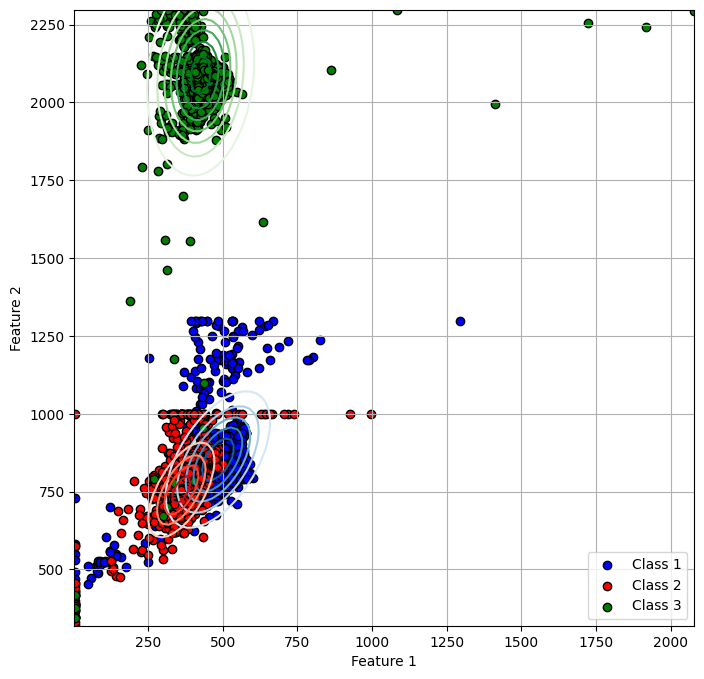

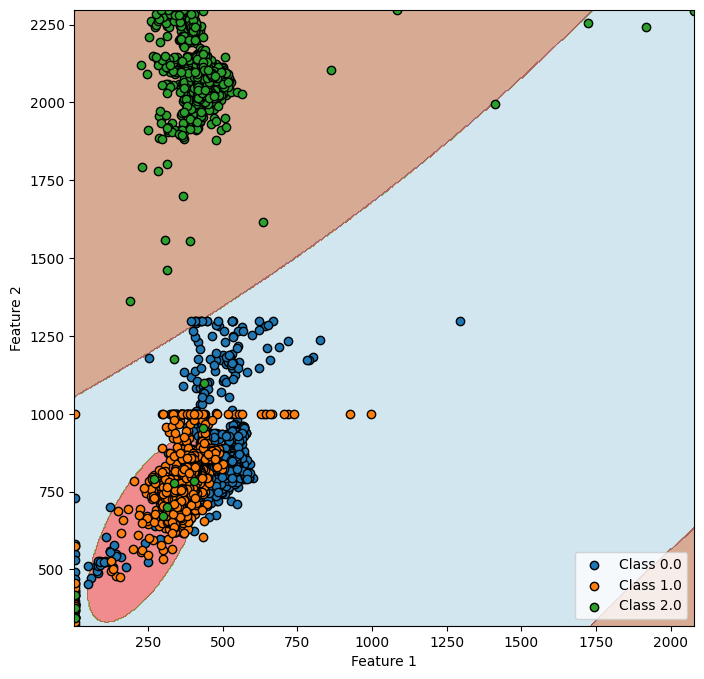

GMM with 2 mixtures:
  Accuracy = 0.9185
              precision    recall  f1-score   support

         0.0       0.91      0.86      0.88       737
         1.0       0.86      0.91      0.89       747
         2.0       1.00      0.99      0.99       688

    accuracy                           0.92      2172
   macro avg       0.92      0.92      0.92      2172
weighted avg       0.92      0.92      0.92      2172

Confusion Matrix:
[[632 103   2]
 [ 64 682   1]
 [  1   6 681]]



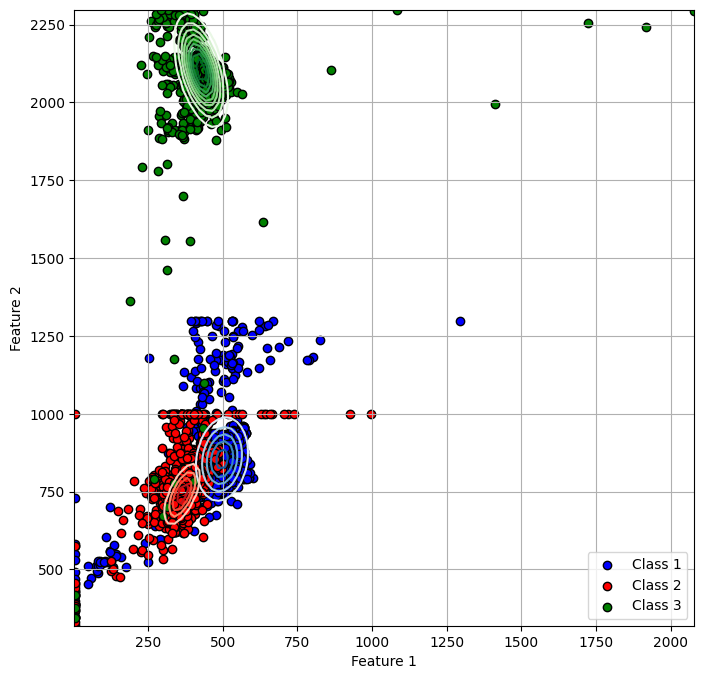

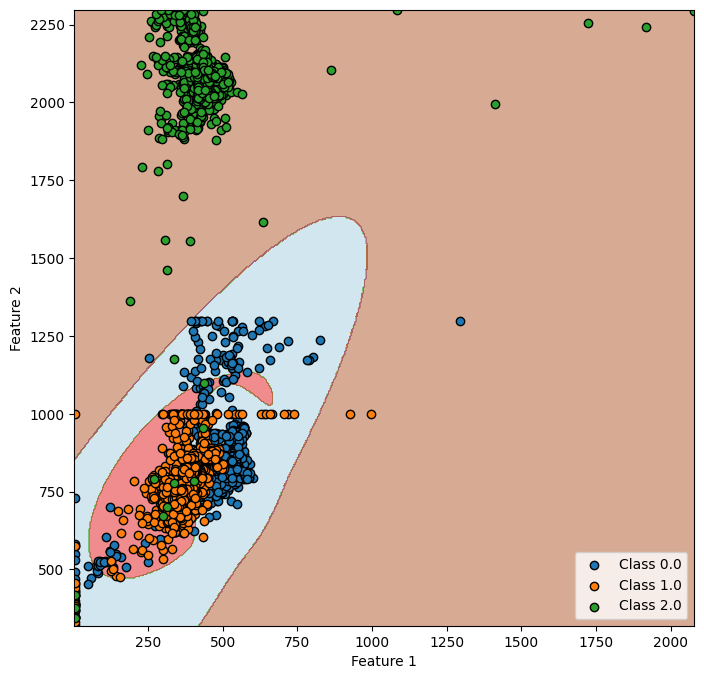

GMM with 4 mixtures:
  Accuracy = 0.9342
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91       737
         1.0       0.90      0.91      0.91       747
         2.0       1.00      0.99      0.99       688

    accuracy                           0.93      2172
   macro avg       0.94      0.94      0.94      2172
weighted avg       0.93      0.93      0.93      2172

Confusion Matrix:
[[668  68   1]
 [ 66 680   1]
 [  3   4 681]]



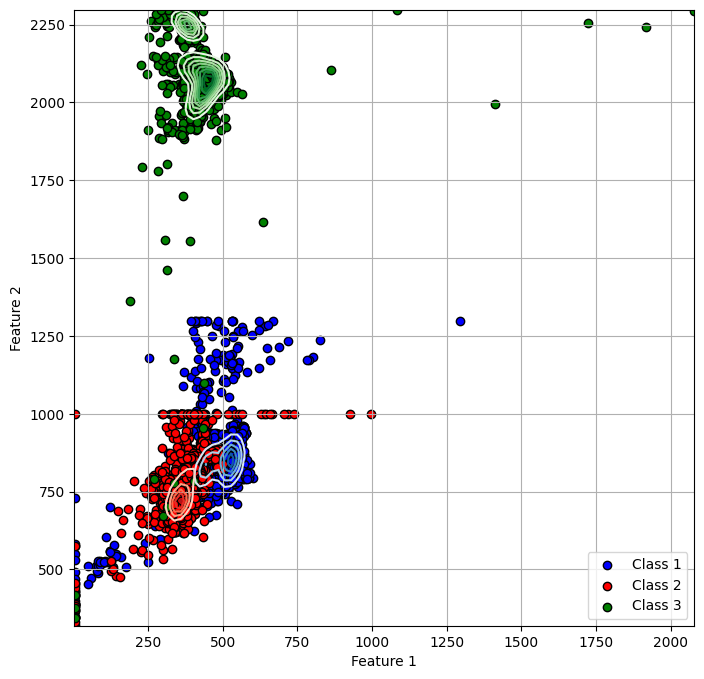

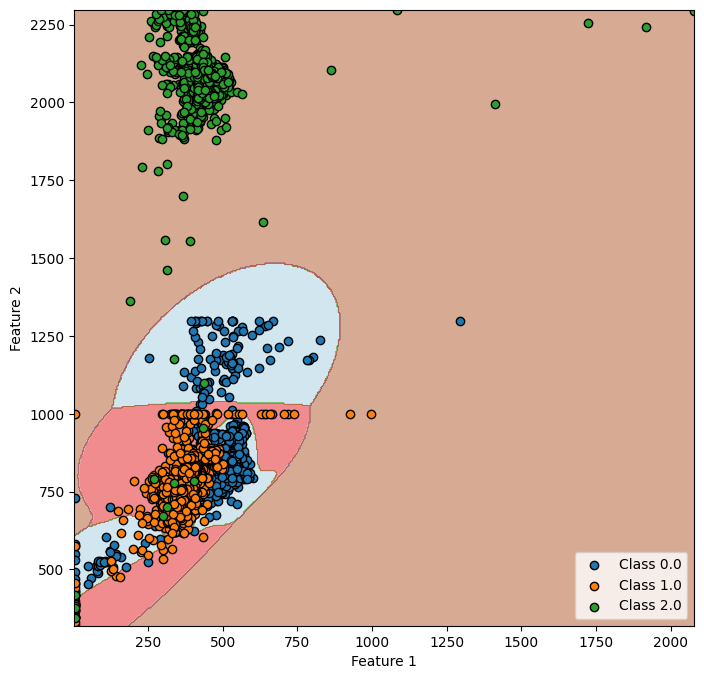

GMM with 8 mixtures:
  Accuracy = 0.9342
              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90       737
         1.0       0.89      0.93      0.91       747
         2.0       1.00      0.99      0.99       688

    accuracy                           0.93      2172
   macro avg       0.94      0.94      0.94      2172
weighted avg       0.93      0.93      0.93      2172

Confusion Matrix:
[[653  83   1]
 [ 50 696   1]
 [  4   4 680]]



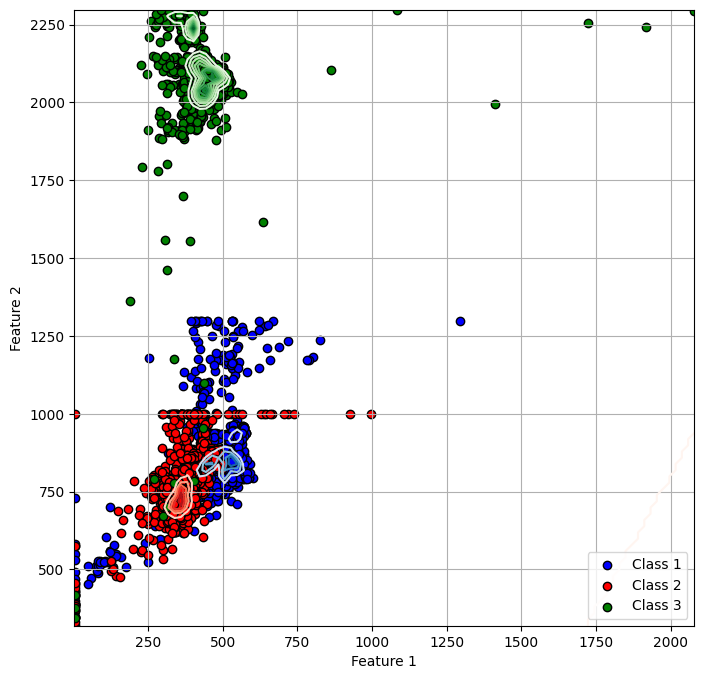

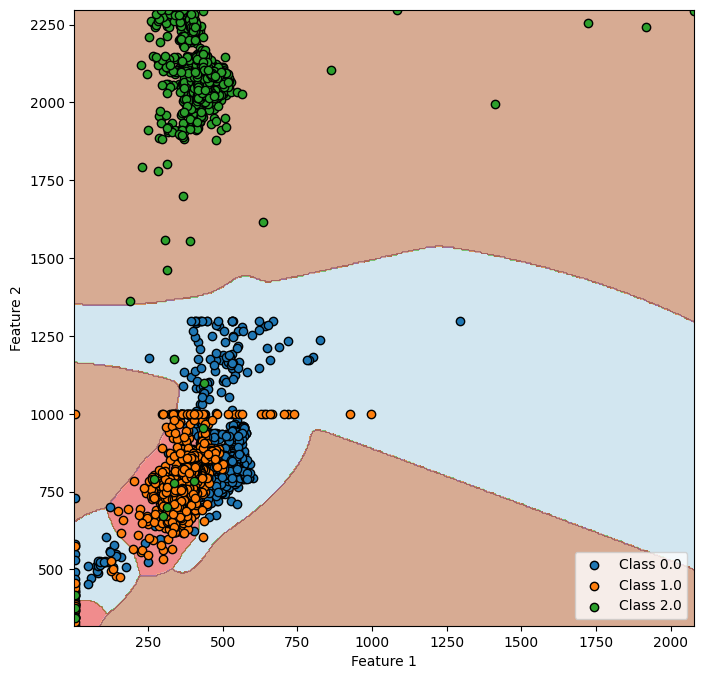

GMM with 16 mixtures:
  Accuracy = 0.9383
              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91       737
         1.0       0.90      0.93      0.91       747
         2.0       1.00      0.99      0.99       688

    accuracy                           0.94      2172
   macro avg       0.94      0.94      0.94      2172
weighted avg       0.94      0.94      0.94      2172

Confusion Matrix:
[[663  74   0]
 [ 52 694   1]
 [  3   4 681]]



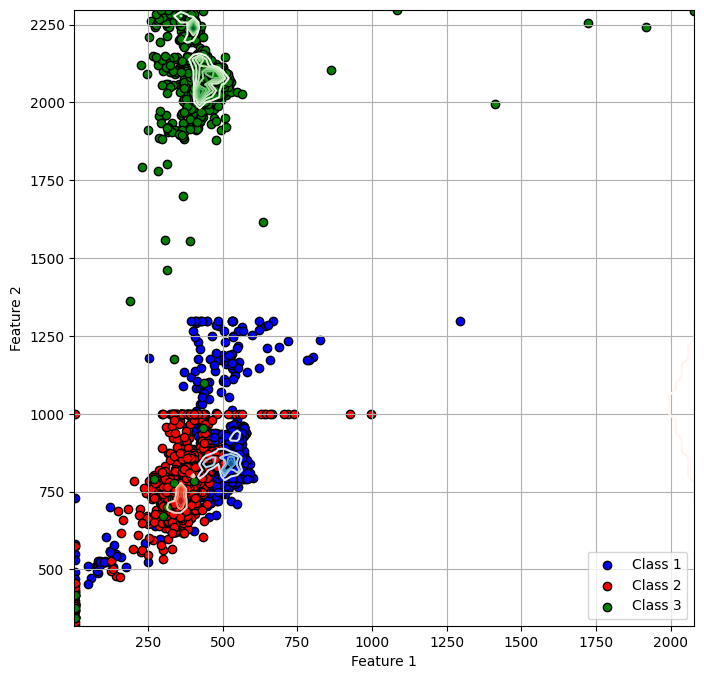

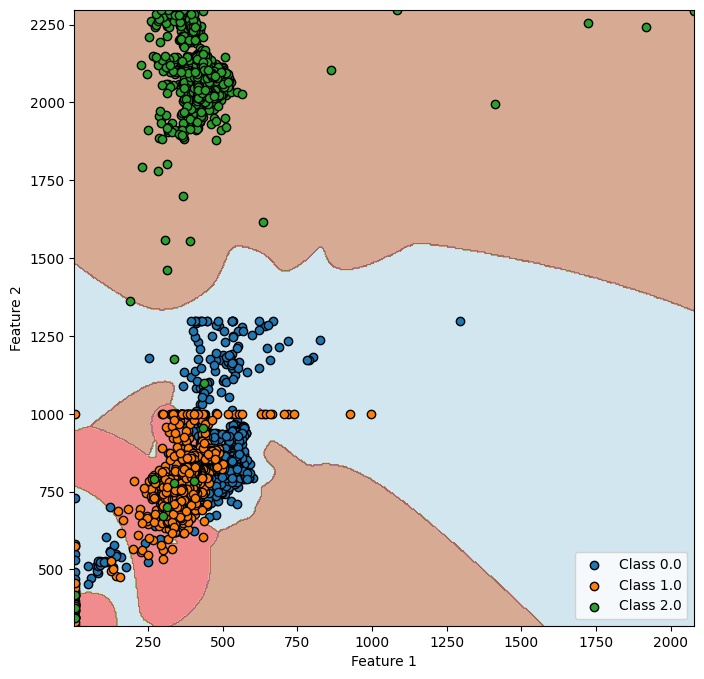

<ipython-input-7-ab09b70d7397>:10: RuntimeWarning: Mean of empty slice.
  new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(n_clusters)])
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
<ipython-input-9-ef7d5c887953>:4: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariances = np.array([np.cov(X[labels == i].T) for i in range(n_components)])
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/linalg/linalg.py:2180: Runt

GMM with 32 mixtures:
  Accuracy = 0.3393
              precision    recall  f1-score   support

         0.0       0.34      1.00      0.51       737
         1.0       0.00      0.00      0.00       747
         2.0       0.00      0.00      0.00       688

    accuracy                           0.34      2172
   macro avg       0.11      0.33      0.17      2172
weighted avg       0.12      0.34      0.17      2172

Confusion Matrix:
[[737   0   0]
 [747   0   0]
 [688   0   0]]



/usr/local/lib/python3.10/dist-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/usr/local/lib/python3.10/dist-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


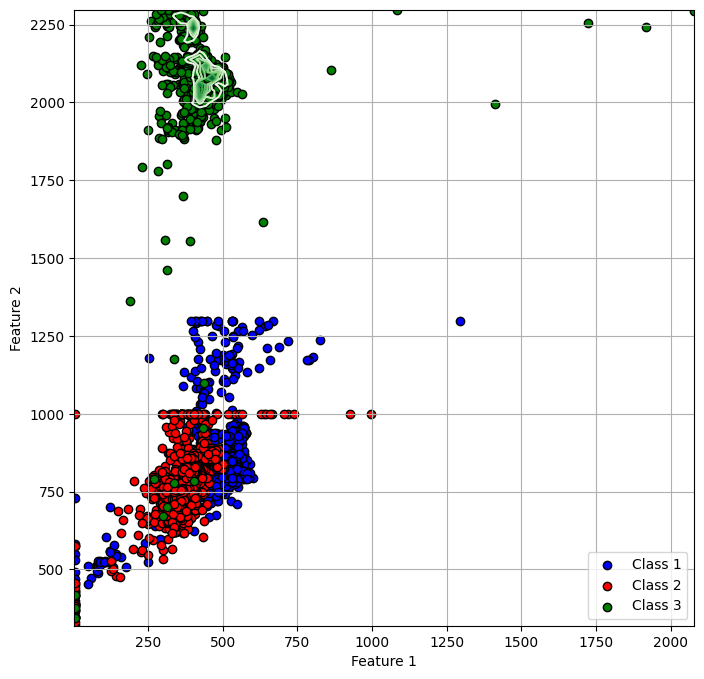

KeyboardInterrupt: 

In [ ]:
n_mixtures_list = [1, 2, 4, 8, 16, 32, 64]
results = run_experiment(X_train[:len(X_train_class1)], X_train[len(X_train_class1):len(X_train_class1)+len(X_train_class2)],
                             X_train[len(X_train_class1)+len(X_train_class2):], X_test, y_test, n_mixtures_list)

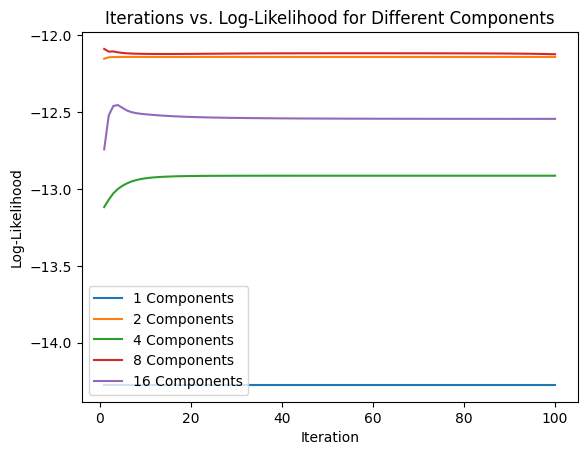

In [ ]:
def gmm_em_with_log_likelihood(X, n_components, max_iter=5):
    n_samples, n_features = X.shape
    means, covariances, priors = initialize_gmm_params(X, n_components)
    log_likelihoods = []

    for iter_num in range(max_iter):
        # E-step
        responsibilities = np.zeros((n_samples, n_components))
        for i in range(n_components):
            for j in range(n_samples):
                responsibilities[j, i] = priors[i] * gaussian_density(X[j], means[i], covariances[i])
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        # M-step
        N_k = responsibilities.sum(axis=0)
        means = np.array([np.dot(responsibilities[:, k], X) / N_k[k] for k in range(n_components)])
        covariances = np.array([np.dot((responsibilities[:, k] * (X - means[k]).T), (X - means[k])) / N_k[k] for k in range(n_components)])
        priors = N_k / n_samples

        # Calculate log-likelihood
        log_likelihood = np.sum(np.log(np.sum([priors[i] * gaussian_density(X[j], means[i], covariances[i]) for i in range(n_components)], axis=0)))
        log_likelihoods.append(log_likelihood)

    return means, covariances, priors, log_likelihoods

n_components_list = [1,2, 4, 8,16]
max_iter = 100

for n_components in n_components_list:
    _, _, _, log_likelihoods = gmm_em_with_log_likelihood(X_train, n_components, max_iter)
    plt.plot(range(1, max_iter + 1), log_likelihoods, label=f'{n_components} Components')

plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.title('Iterations vs. Log-Likelihood for Different Components')
plt.legend(loc='best')
plt.show()

<ipython-input-7-ab09b70d7397>:10: RuntimeWarning: Mean of empty slice.
  new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(n_clusters)])
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
<ipython-input-9-ef7d5c887953>:4: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariances = np.array([np.cov(X[labels == i].T) for i in range(n_components)])
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


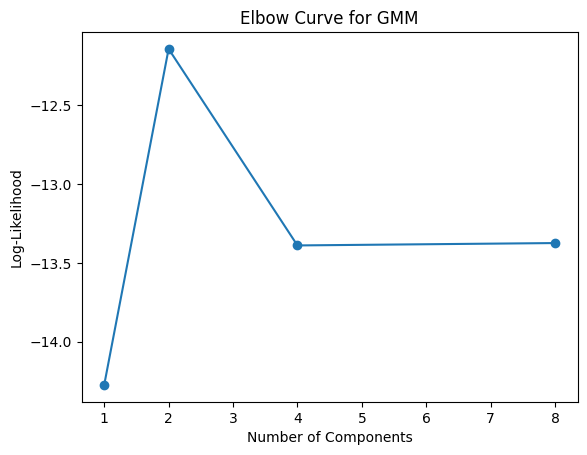

In [ ]:
def gmm_em_with_log_likelihood(X, n_components, max_iter=5):
    n_samples, n_features = X.shape
    means, covariances, priors = initialize_gmm_params(X, n_components)
    log_likelihoods = []

    for iter_num in range(max_iter):
        # E-step
        responsibilities = np.zeros((n_samples, n_components))
        for i in range(n_components):
            for j in range(n_samples):
                responsibilities[j, i] = priors[i] * gaussian_density(X[j], means[i], covariances[i])
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        # M-step
        N_k = responsibilities.sum(axis=0)
        means = np.array([np.dot(responsibilities[:, k], X) / N_k[k] for k in range(n_components)])
        covariances = np.array([np.dot((responsibilities[:, k] * (X - means[k]).T), (X - means[k])) / N_k[k] for k in range(n_components)])
        priors = N_k / n_samples

        # Calculate log-likelihood
        log_likelihood = np.sum(np.log(np.sum([priors[i] * gaussian_density(X[j], means[i], covariances[i]) for i in range(n_components)], axis=0)))
        log_likelihoods.append(log_likelihood)

    return means, covariances, priors, log_likelihoods

n_components_list = [1,2, 4, 8,16]
max_iter = 10
log_likelihoods_for_elbow = []

for n_components in n_components_list:
    _, _, _, log_likelihoods = gmm_em_with_log_likelihood(X_train, n_components, max_iter)
    log_likelihoods_for_elbow.append(log_likelihoods[-1])  # Append the final log-likelihood

plt.plot(n_components_list, log_likelihoods_for_elbow, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Log-Likelihood')
plt.title('Elbow Curve for GMM')
plt.show()